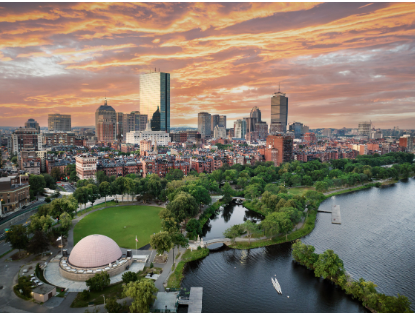

Airbnb is an online marketplace for arranging or offering lodging, primarily homestays, or tourism experiences. Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities. It renders a unique and personalized way of experiencing the world and socializing with new people. This dataset describes the listing activity and metrics in Boston, MA for 2019. This data file includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions, and draw conclusions.

## **Import Library**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from tqdm import tqdm
import plotly.express as px

%matplotlib inline

# Import necessary libraries for performing prediction
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression


## **Data Load**

In [8]:
def load_data():
    df = pd.read_csv('../input/boston/listings.csv')
    df_cal = pd.read_csv("/kaggle/input/boston/calendar.csv")
    return df, df_cal

df, df_cal = load_data()

## **Price preprocessing**

*   **Object to Float**

In [9]:
def preprocess_price(df):
    price_b = [float(i[1:].replace(',', '')) for i in df['price']]
    df['price'] = price_b
    return df

df = preprocess_price(df)


## **Data Preparation - Calendar data - df_cal**

In [10]:
def preprocess_calendar_data(df_cal):
    # Extract month from dates column
    df_cal['month'] = df_cal.date.apply(lambda value: value.split('-')[1])
    df_cal['month'] = df_cal['month'].replace({
        '01': 'Jan',
        '02': 'Feb',
        '03': 'Mar',
        '04': 'Apr',
        '05': 'May',
        '06': 'Jun',
        '07': 'Jul',
        '08': 'Aug',
        '09': 'Sep',
        '10': 'Oct',
        '11': 'Nov',
        '12': 'Dec'
    })

    # Remove special character $ from price column and convert to float
    # Drop rows with na value in price column, as we have enough rows of data to gain confidence 
    df_cal.dropna(axis=0, subset=["price"], inplace=True)
    df_cal["price"] = df_cal["price"].map(lambda x: x.replace("$", '').replace(",", ''), na_action='ignore').astype(float)
    return df_cal

df_cal = preprocess_calendar_data(df_cal)


## **Feature Engineering**

### **Q1) Which columns are influential?**

#### **Corr of Price Column**

In [13]:
def calculate_price_correlation(df):
    price_corr = df.corr()['price'].sort_values(ascending=False).head(6)[1:]
    return price_corr

price_corr = calculate_price_correlation(df)


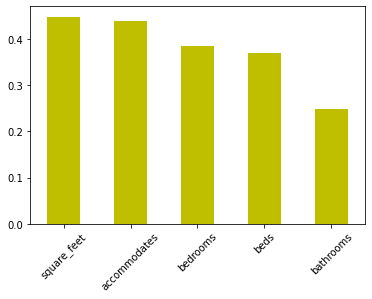

In [14]:
def plot_price_correlation(price_corr):
    price_corr.plot(kind='bar', color='y')
    plt.xticks(rotation=45)
    plt.show()

plot_price_correlation(price_corr)


#### **Result**

It seems that **area variable** is most important. (We can easily guess)

Maybe Accommodates, Bedrooms, Beds... columns are related to **area & price!**

### **Q2) Which street is most expensive?**

#### **Preprocessing Street Column**

- From street column, Extracting Street Name

In [15]:
def preprocess_street_column(df):
    df['street'] = df['street'].apply(lambda x: x.split(',')[0])
    return df

df = preprocess_street_column(df)


#### **Visualization**

- Top 5 Rich Street By Our Data

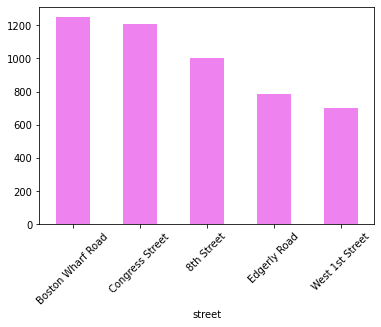

In [16]:
def plot_top_expensive_streets(df):
    top_streets = df.groupby('street')['price'].mean().sort_values(ascending=False).head(5)
    top_streets.plot(kind='bar', color='violet')
    plt.xticks(rotation=45)
    plt.show()

plot_top_expensive_streets(df)


#### **Result**

By google map, these streets are near by ocean!

Actually, I'm not living in boston(I'm korean). But I can guess that those streets are rich.

### **Q3) Relationship between Review of AIRBNB Data & Host info**

I wondered about relationship between review data and host-info!

At first, I counted positive & negative words in review data.

And merged this data with DataFrame 'df'

#### **Preprocessing**

*  **Counting Postive & Negative words in Review Data**
*  **Merging DataFrame**
*  **Filling Missing Values (-1)**

In [17]:
def count_words_in_reviews(df_re, positive_words, negative_words):
    ls_good = []
    ls_bad = []

    for c in range(len(df_re)):
        n_good = 0
        n_bad = 0
        try:
            for word in df_re['comments'][c].split():
                if word in positive_words:
                    n_good += 1
                if word in negative_words:
                    n_bad += 1
        except:
            n_good = 0
            n_bad = 0
        ls_good.append(n_good)
        ls_bad.append(n_bad)

    df_re['counts_good'] = ls_good
    df_re['counts_bad'] = ls_bad
    return df_re

positive_words = ['good', 'clean', 'nice', 'great', 'Great', 'Nice', 'comfortable', 'Good', 'cool', 'Cool', 'Clean', 'enjoyed', 'bien', 'ajustado', 'cozy', 'Cozy']
negative_words = ['bad', 'dirty', 'uncomfortable', 'terrible', 'Bad', 'Dirty', 'Uncomfortable', 'sucio', 'malo', 'incómodo']

df_re = pd.read_csv('../input/boston/reviews.csv')
df_re = count_words_in_reviews(df_re, positive_words, negative_words)

# Merging
df_re = df_re[['listing_id', 'counts_good', 'counts_bad']]
df_re.columns = ['id', 'counts_good', 'counts_bad']
df = pd.merge(df, df_re, on='id', how='left')

# Filling Missing Values
df['counts_good'] = df['counts_good'].fillna(-1)
df['counts_bad'] = df['counts_bad'].fillna(-1)


#### **Visualization**

##### **Review values - Word counts**

100%|██████████| 7/7 [00:14<00:00,  2.06s/it]


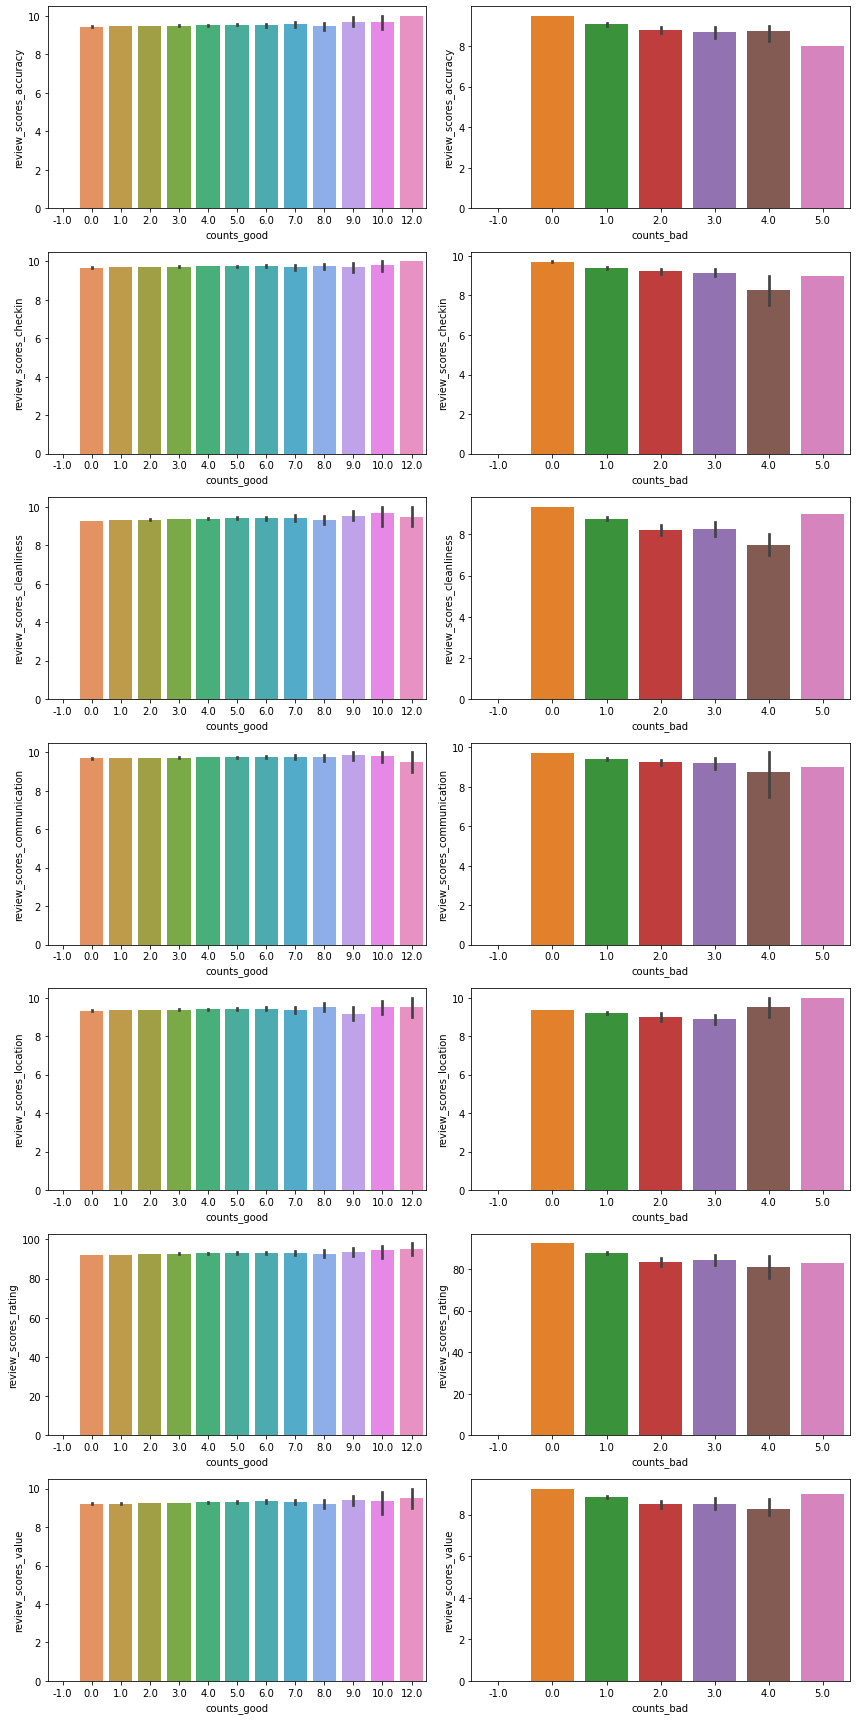

In [18]:
def plot_review_word_counts(df, review_cols):
    fig, ax = plt.subplots(len(review_cols), 2, figsize=(12, 24))

    for i in tqdm(range(len(review_cols))):
        sns.barplot(df['counts_good'], df[review_cols[i]], ax=ax[i, 0])
        sns.barplot(df['counts_bad'], df[review_cols[i]], ax=ax[i, 1])

    plt.tight_layout()
    plt.show()

review_cols = ['review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_rating', 'review_scores_value']
plot_review_word_counts(df, review_cols)


##### **Price - Word counts**

100%|██████████| 7/7 [00:15<00:00,  2.17s/it]


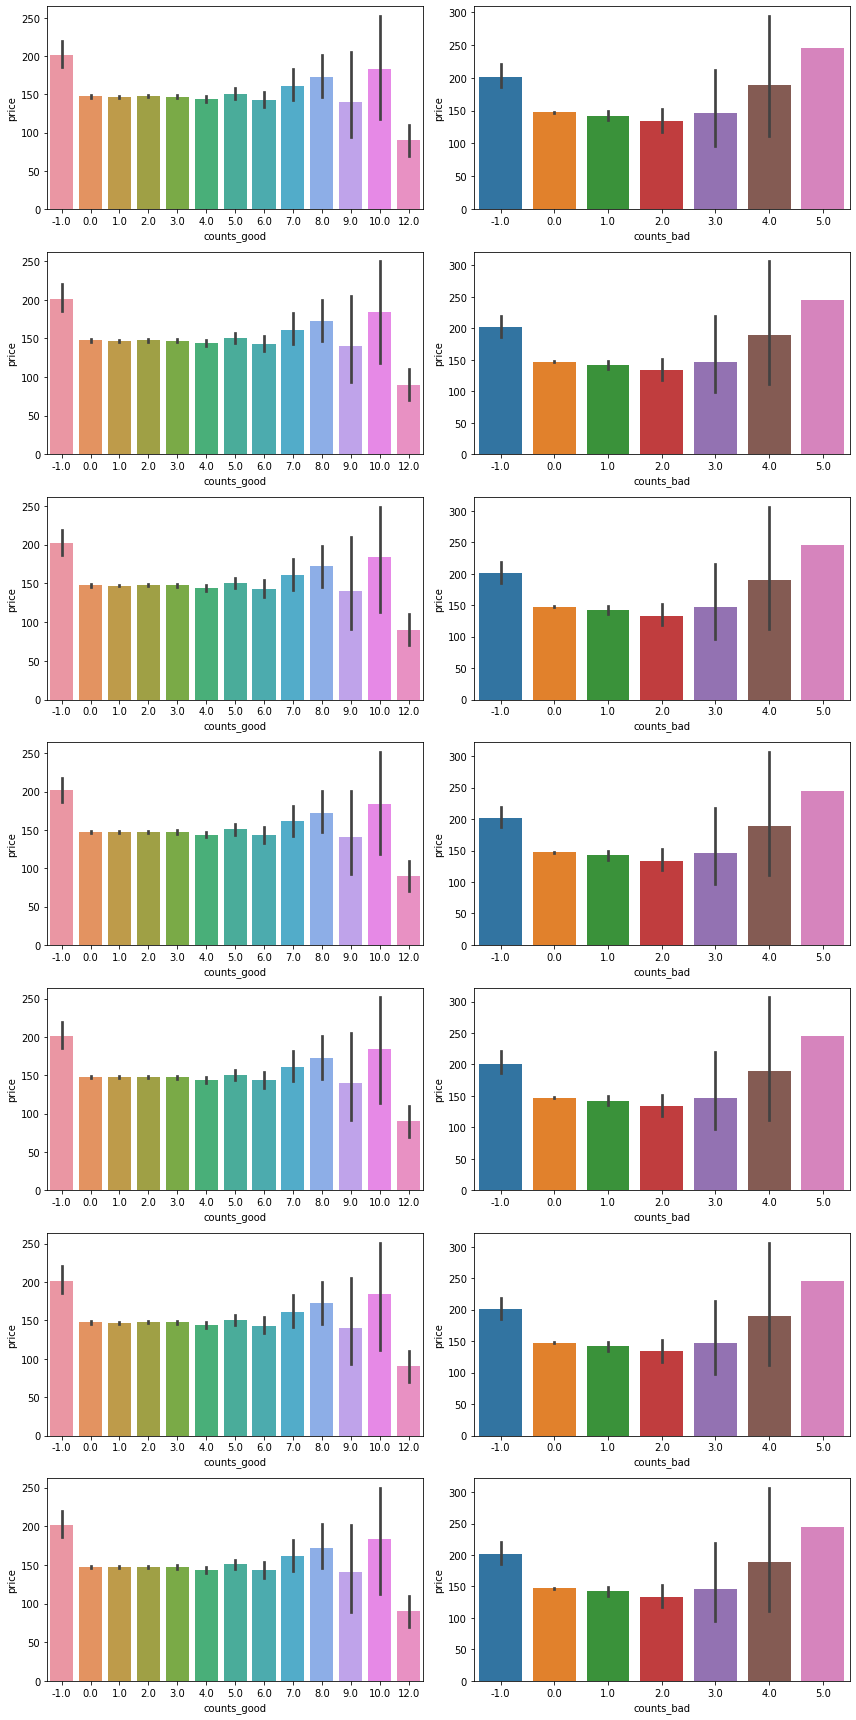

In [19]:
def plot_price_word_counts(df, review_cols):
    fig, ax = plt.subplots(len(review_cols), 2, figsize=(12, 24))

    for i in tqdm(range(len(review_cols))):
        sns.barplot(df['counts_good'], df['price'], ax=ax[i, 0])
        sns.barplot(df['counts_bad'], df['price'], ax=ax[i, 1])

    plt.tight_layout()
    plt.show()

plot_price_word_counts(df, review_cols)
